In [1]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# ### Load data (one file)
# file = "../data/onetrack_multicluster/pion_files/001.npy"
# event_data = np.load(file, allow_pickle=True).item()
# df = pd.DataFrame(event_data)

In [3]:
### Load data (multiple files)
n_files = 100
files = glob.glob("../data/onetrack_multicluster/pion_files/*.npy")
df = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[:n_files])])
print("Dataframe has {:,} events.".format(df.shape[0]))

100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Dataframe has 1,027,650 events.


In [5]:
### Start the dataframe of inputs 
max_n_clusters = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list())).shape[1]
df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list(), columns=["cluster_e_"+str(x) 
                                                                 for x in np.arange(max_n_clusters)]))
df2 = pd.DataFrame(df2["cluster_e_0"]) # only keep the leading cluster energy

max_n_clusters = pd.DataFrame(pd.DataFrame(df.cluster_ENG_CALIB_TOT.to_list())).shape[1]
df3 = pd.DataFrame(pd.DataFrame(df.cluster_ENG_CALIB_TOT.to_list(), columns=["cluster_calib_e_"+str(x) 
                                                                 for x in np.arange(max_n_clusters)]))
df2["cluster_calib_e_0"] = pd.DataFrame(df3["cluster_calib_e_0"]) # only keep the leading cluster energy

### Add track pT & truth particle E 
track_pt = np.array(df.trackPt.explode())
truth_particle_e = np.array(df.truthPartE.explode())
track_eta = np.array(df.trackEta.explode())
track_phi = np.array(df.trackPhi.explode())
track_z0 = np.array(df.trackZ0.explode())

df2["track_pt"] = track_pt
df2["track_eta"] = track_eta
df2["track_phi"] = track_phi
df2["track_z0"] = track_z0
df2["truth_particle_e"] = truth_particle_e

### Drop infs/NaNs 
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df2 = df2.fillna(0)

### Cluster_E > 0.5
df2 = df2[df2.cluster_e_0 > 0.5]

### Lose outliers in track pT 
df2 = df2[df2.track_pt < 5000]

### Cast as float
df2 = df2.astype('float32')

### Add the log of all energy variables
for var in df2.keys():
    if var in ["track_eta", "track_phi", "track_z0"]:
        continue
    else:
        df2['log10_'+var] = np.log10(df2[var])
    
### Do this again? 
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df2 = df2.fillna(0)

/clusterfs/ml4hep/mpettee/miniconda3/envs/nbdev/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/clusterfs/ml4hep/mpettee/miniconda3/envs/nbdev/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
df2.keys()

Index(['cluster_e_0', 'cluster_calib_e_0', 'track_pt', 'track_eta',
       'track_phi', 'track_z0', 'truth_particle_e', 'log10_cluster_e_0',
       'log10_cluster_calib_e_0', 'log10_track_pt', 'log10_truth_particle_e'],
      dtype='object')

In [ ]:
### Inspect variables 
sns.set(font_scale = 2)
corr_vars = ['truth_particle_e', 'cluster_calib_e_0', 'cluster_e_0', 'track_pt', 'track_eta']
g = sns.pairplot(df2[corr_vars], diag_kind='kde')
g.fig.set_figheight(12)
g.fig.set_figwidth(12)

In [ ]:
df2.keys()

In [23]:
### Test/train split 
train = df2.sample(frac=0.8, random_state=0)
test = df2.drop(train.index)

train_vars = [
#     'log10_cluster_e_0', 
    'log10_cluster_calib_e_0',
#     'log10_track_pt',
#     'track_eta'
             ]

# target_var = 'log10_truth_particle_e'
target_var = 'log10_cluster_e_0'

### All clusters + track eta/phi/z0
# train_vars = [var for var in df2.keys() if var.startswith('log10') and var != 'log10_truth_particle_e']
# train_vars += ['track_eta', 'track_phi', 'track_z0']

train_x = train[train_vars].values
train_y = train[target_var].values
test_x = test[train_vars].values
test_y = test[target_var].values

In [24]:
### Normalize the inputs 
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
test_x = sc.transform(test_x)

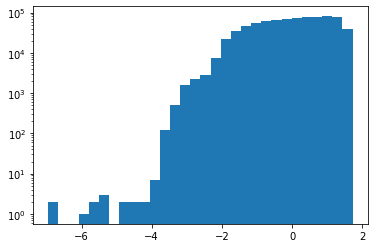

In [25]:
plt.hist(train_x[:,0], bins=30);
plt.yscale('log');

In [26]:
def regression_model():
    model = Sequential()
    model.add(Dense(50, input_dim=train_x.shape[1], activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [27]:
model = regression_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 5,251
Trainable params: 5,251
Non-trainable params: 0
_________________________________________________________________


In [28]:
%%time
history = model.fit(
    train_x,
    train_y,
    validation_split=0.2,
    verbose=1, epochs=10)

Epoch 1/10
20082/20082 [==============================] - 43s 2ms/step - loss: 0.0153 - val_loss: 0.0100
Epoch 2/10
20082/20082 [==============================] - 44s 2ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 3/10
20082/20082 [==============================] - 44s 2ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 4/10
20082/20082 [==============================] - 44s 2ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 5/10
20082/20082 [==============================] - 44s 2ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 6/10
20082/20082 [==============================] - 44s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 7/10
20082/20082 [==============================] - 44s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 8/10
20082/20082 [==============================] - 44s 2ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 9/10
20082/20082 [==============================] - 44s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 10/10
20082/20082 [==============================

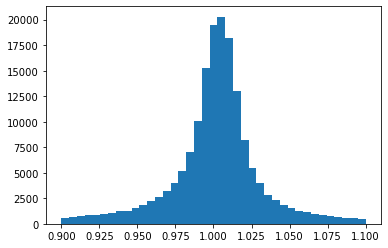

In [29]:
### Evaluate performance on test set 
test['nn_score'] = model.predict(test_x)
plt.hist(test.nn_score/test_y, bins=np.linspace(0.9,1.1,40));

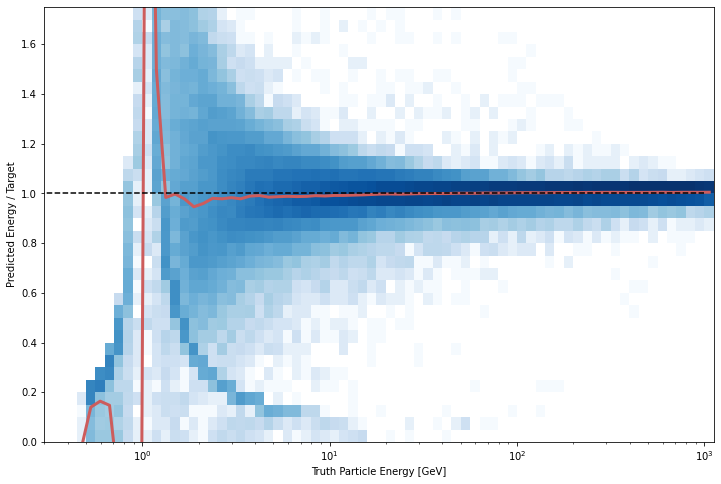

In [30]:
### Response median plot 
import scipy.stats as stats
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

x = 10**test_y #test.truth_particle_etest_y #
y = test.nn_score/test_y #test.log10_truth_particle_e

xbin = [10**exp for exp in np.arange(-1., 3.1, 0.05)]
ybin = np.arange(0., 3.1, 0.05)
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
profileXMed = stats.binned_statistic(
    x, y, bins=xbin, statistic='median').statistic

c_map = ListedColormap(sns.color_palette("Blues", n_colors=100).as_hex())
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')
plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1, cmap=c_map);
plt.plot(np.array(xcenter), np.array(profileXMed), color='indianred', linewidth=3)
plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black');
plt.xscale('log')
plt.ylim(0, 1.75)
plt.xlim(0.3, )
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Predicted Energy / Target');
np.savez('pub_note_results/response_medians_clustercalibEinput_clusterEtarget.npz', response_median=profileXMed, xcenter=xcenter)

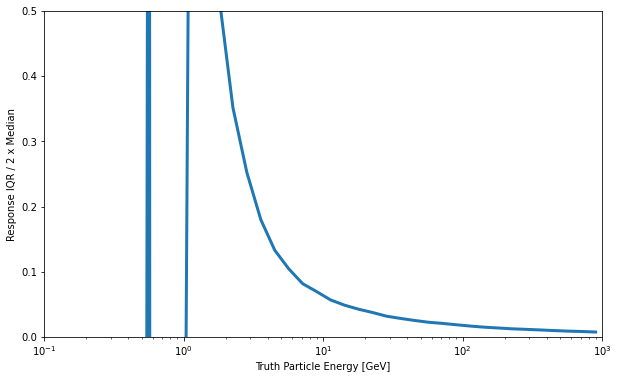

In [31]:
### IQR plot 

def iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q84, q16 = np.percentile(x, [84, 16])
    iqr = q84 - q16
    med = np.median(x)
    return iqr / (2*med)

xbin = [10**exp for exp in np.arange(-1., 3.1, 0.1)]
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
resolution = stats.binned_statistic(x, y, bins=xbin, statistic=iqrOverMed).statistic

fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('white')
plt.plot(xcenter, resolution, linewidth=3)
plt.xscale('log')
plt.xlim(0.1, 1000)
plt.ylim(0,0.5)
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Response IQR / 2 x Median');

np.savez('pub_note_results/iqr_simple_clustercalibEinput_clusterEtarget.npz', iqr=resolution, xcenter=xcenter)